In [0]:
from PIL import Image
import numpy as np
from sklearn.neighbors  import KNeighborsClassifier, DistanceMetric
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import pandas as pd
import math
import random


In [0]:
dataset_image_1 = "dataset_picture1.png"
dataset_image_2 = "dataset_picture2.png"
dataset_image_3 = "dataset_picture3.png"

In [0]:
rgb_code_dictionary={(255,255,255): -1, (0,0,0):0, (255,0,0):1, (0,255,0):2, (0,0,255):3 }

def distance(c1, c2):
    (r1,g1,b1) = c1
    (r2,g2,b2) = c2
    return math.sqrt((r1 - r2)**2 + (g1 - g2) ** 2 + (b1 - b2) **2)
def get_closest(point):
  colors = list(rgb_code_dictionary.keys())
  closest_colors = sorted(colors, key=lambda color: distance(color, point))
  closest_color = closest_colors[0]
  code = rgb_code_dictionary[closest_color]
  return code

In [0]:
def add_noise(X):
  rand = random.gauss(0, 1)
  return X + rand

def divide_dataset(X):
  np.random.shuffle(X)
  training, test = X[:math.floor(0.7*X.shape[0]),:], X[math.floor(0.7*X.shape[0]):,:]
  return training, test
  

In [0]:
def write_data_to_csv(source: str, dest_path: str):
    image = Image.open(source)
    width, height = image.size
    with open(dest_path, 'w') as dest_file:
        for x in range(0, width):
            for y in range(0, height):
              if(get_closest(image.getpixel((x,y))[0:3])!=-1):
                dest_file.write(f'{add_noise(x)};{add_noise(y)};{get_closest(image.getpixel((x,y))[0:3])}\n')


In [0]:
write_data_to_csv(dataset_image_1, "dataset_1.csv")
write_data_to_csv(dataset_image_2, "dataset_2.csv")
write_data_to_csv(dataset_image_3, "dataset_3.csv")

In [0]:
dataset1 = 'dataset_1.csv'
dataset2 = 'dataset_2.csv'
dataset3 = 'dataset_3.csv'

In [0]:
def read_dataset_from_csv(dataset):
  dataset_df = pd.read_csv(dataset, sep=';', names=['x', 'y', 'label'])
  X = dataset_df.iloc[:, 0:2]
  y = dataset_df.iloc[:, 2]
  return(X,y)

In [0]:
def calculate_decision_boundry(X, y,X_test,y_test,k,weights,metric,cmap_light,cmap_bold,**kwargs ):
  
  clf = KNeighborsClassifier(k, weights=weights, metric=metric, **kwargs)
  clf.fit(X, y)

  h = 0.1
  
  #Check correctness of clasification
  Q = clf.predict(X_test)
  accuracy = np.sum(Q == y_test)/y_test.size
  print("Accuracy: {}".format(accuracy))

  # Plot the decision boundary. For that, we will assign a color to each
  # point in the mesh [x_min, x_max]x[y_min, y_max].
  x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
  y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
  Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

  # Put the result into a color plot
  Z = Z.reshape(xx.shape)
  plt.figure()
  plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

  # Plot also the training points
  plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cmap_bold, edgecolor='k', s=20)
  plt.xlim(xx.min(), xx.max())
  plt.ylim(yy.min(), yy.max())
  plt.gca().invert_yaxis()
  plt.xlabel("picture x coordinates")
  plt.ylabel("picture y coordinates")

  plt.title("{}-Class classification (k = {}, weights = {}, metric = {})".format(cmap_bold.N, k, weights, metric))

In [0]:
X, y = read_dataset_from_csv(dataset1)
training_, test_ = divide_dataset(np.c_[X, y])
X, y = training_[:,:2], training_[:,2]
X_test, y_test = test_[:,:2], test_[:,2]


In [0]:
cmap_light = ListedColormap(['#DCDCDC','#FFC0CB'])
cmap_bold = ListedColormap(['#000000','#FF0000'])

Accuracy: 0.8639175257731959


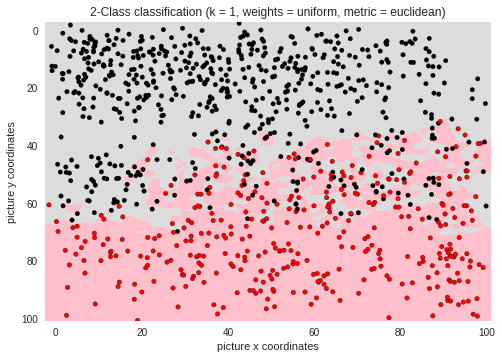

In [32]:
calculate_decision_boundry(X, y,X_test,y_test, 1, 'uniform', 'euclidean',cmap_light,cmap_bold)

Accuracy: 0.877319587628866


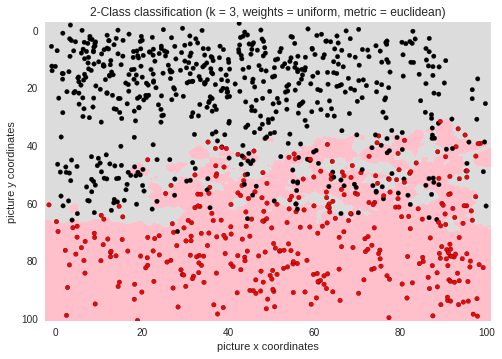

In [33]:
calculate_decision_boundry(X, y,X_test,y_test, 3, 'uniform', 'euclidean',cmap_light,cmap_bold)

Accuracy: 0.8711340206185567


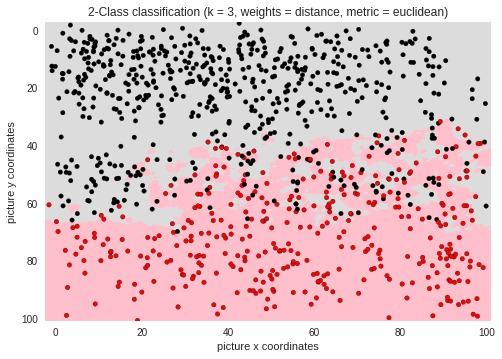

In [34]:
calculate_decision_boundry(X, y,X_test,y_test, 3, 'distance', 'euclidean',cmap_light,cmap_bold)

Accuracy: 0.8690721649484536


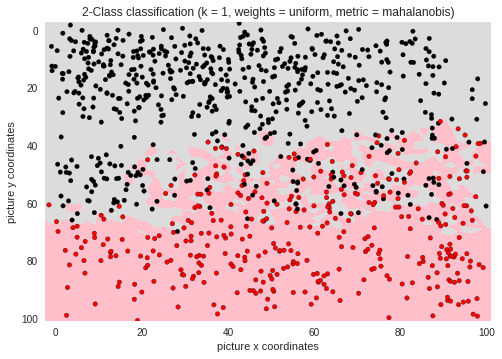

In [35]:
calculate_decision_boundry(X, y,X_test,y_test, 1, 'uniform','mahalanobis',cmap_light,cmap_bold,  metric_params={'VI' :np.linalg.pinv(np.cov(X ,rowvar=False))})

In [0]:
def slice_areas(dataset, number_of_slices, picture_size):
  width = picture_size[0]
  height = picture_size[1]
  bucked_width = width//math.floor(math.sqrt(number_of_slices))
  bucket_height = height/math.floor(math.sqrt(number_of_slices))
  buckets = {}
  for x in range(math.floor(math.sqrt(number_of_slices))):
    bucket_starting_x = x * bucked_width + x
    bucket_ending_x = bucket_starting_x + bucked_width
    for y in range(math.floor(math.sqrt(number_of_slices))):
      bucket_starting_y = y * bucket_height + y
      bucket_ending_y = bucket_starting_y + bucket_height
      buckets[(x,y)] = dataset[(bucket_starting_x <= dataset[:,0]) * (bucket_ending_x >= dataset[:,0]) * (bucket_starting_y <= dataset[:,1]) * (bucket_ending_y >= dataset[:,1])]
  return buckets
  

In [0]:
def knn_mahalanobis_metric_covariance_matrix_from_region(training_, test_):
    k = 1
    weights = 'uniform'
    metric = 'mahalanobis'

    slices = 16
    h = 0.05
    sliced_train_ = slice_areas(training_, slices, (100,100))
    sliced_test_ = slice_areas(test_, slices, (100,100))

    bucked_width = 100/math.floor(math.sqrt(slices))
    bucket_height = 100/math.floor(math.sqrt(slices))

    light = {0:'#DCDCDC', 1: '#FFC0CB',2: '#00FF7F', 3: '#87CEEB' }
    bold = {0: '#000000',1 :'#FF0000',2: '#00FF00',3:'#0000FF'}
    
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    accuracy = 0
    plot = plt.figure()
    for x in range((math.floor(math.sqrt(slices)))):
      for y in range((math.floor(math.sqrt(slices)))):
        train_data = sliced_train_[(x,y)]
        X_train = train_data[:,:2]
        y_train = train_data[:,2]
        test_data = sliced_test_[(x,y)]
        X_test = test_data[:,:2]
        y_test = test_data[:,2]
        if(X_test.shape[0]!=0 and y_test.shape[0]!=0):
          clf = KNeighborsClassifier(k, weights=weights, metric=metric, metric_params={'VI': np.linalg.pinv(np.cov(X_train ,rowvar=False))})
          clf.fit(X_train, y_train)
          Q = clf.predict(X_test)
          acc = np.sum(Q == y_test)/y_test.size
          accuracy+= acc

        bucket_starting_x = x * bucked_width + x
        bucket_ending_x = bucket_starting_x + bucked_width

        bucket_starting_y = y * bucket_height + y
        bucket_ending_y = bucket_starting_y + bucket_height


        x_min, x_max = bucket_starting_x, bucket_ending_x
        y_min, y_max = bucket_starting_y, bucket_ending_y
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        unik = np.unique(Z)
        color_list_bold = []
        color_list_light = []

        for u in unik:
          color_list_bold.append(bold[u])
          color_list_light.append(light[u])

        cmap_light = ListedColormap(color_list_light)
        cmap_bold = ListedColormap(color_list_bold)


        ax1.pcolormesh(xx, yy, Z, cmap=cmap_light)

        # Plot also the training points
        ax1.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cmap_bold, edgecolor='k', s=20)


    print("Accuracy = {}".format(accuracy/slices))  
    # plt.gca().invert_yaxis()
    plt.xlim(100,100)
    plt.ylim(100,100)
    plt.title("%i-Class classification (k = %i, weights = '%s')" % ((cmap_bold.N, k, weights)))
    plt.show()


Accuracy = 0.8620696621505849


/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:2961: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=100, right=100
  'left=%s, right=%s') % (left, right))
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:3285: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=100, top=100
  'bottom=%s, top=%s') % (bottom, top))


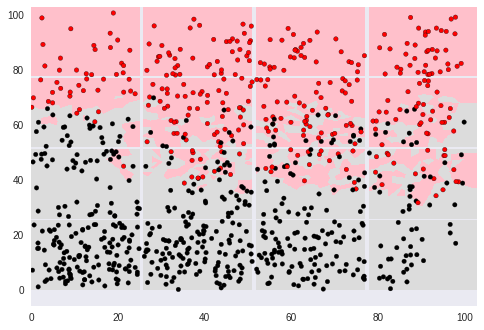

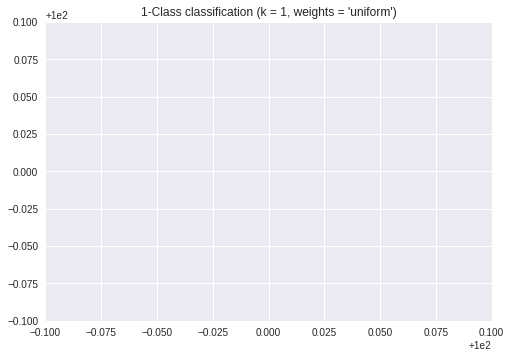

In [38]:
knn_mahalanobis_metric_covariance_matrix_from_region(training_, test_)

In [0]:
X, y = read_dataset_from_csv(dataset2)
training_, test_ = divide_dataset(np.c_[X, y])
X, y = training_[:,:2], training_[:,2]
X_test, y_test = test_[:,:2], test_[:,2]

In [0]:
cmap_light = ListedColormap(['#FFC0CB',  '#00FF7F', '#87CEEB'])
cmap_bold = ListedColormap([ '#FF0000', '#00FF00','#0000FF'])

Accuracy: 0.987460815047022


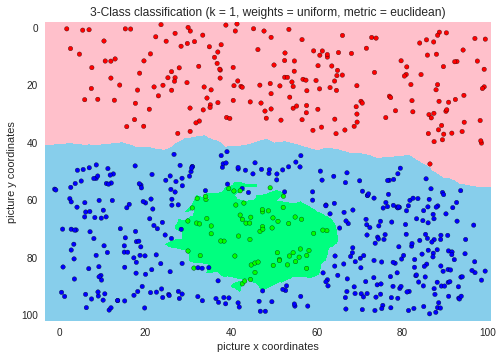

In [49]:
calculate_decision_boundry(X, y,X_test,y_test, 1, 'uniform', 'euclidean',cmap_light,cmap_bold)

Accuracy: 0.9843260188087775


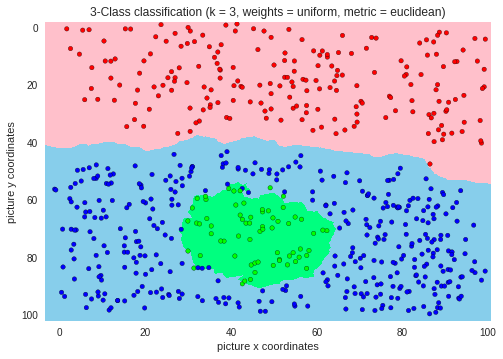

In [50]:
calculate_decision_boundry(X, y,X_test,y_test, 3, 'uniform', 'euclidean',cmap_light,cmap_bold)

Accuracy: 0.9858934169278997


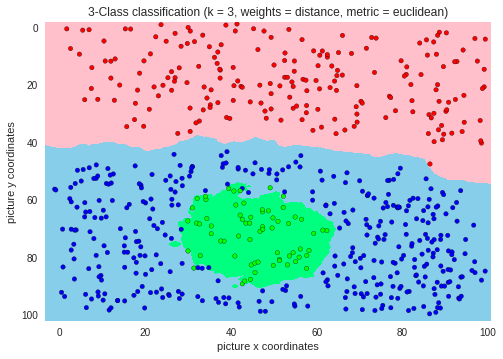

In [53]:
calculate_decision_boundry(X, y,X_test,y_test, 3, 'distance', 'euclidean',cmap_light,cmap_bold)

Accuracy: 0.9265536723163842


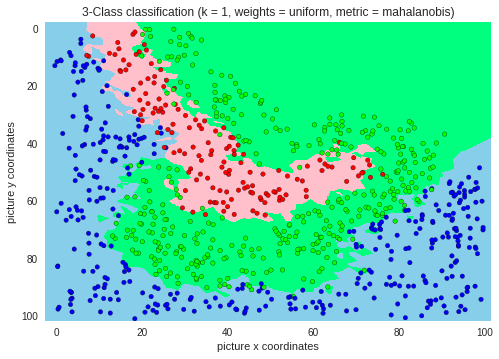

In [56]:
calculate_decision_boundry(X, y,X_test,y_test, 1, 'uniform','mahalanobis',cmap_light,cmap_bold,  metric_params={'VI' :np.linalg.pinv(np.cov(X ,rowvar=False))})

Accuracy = 0.8112302653918648


/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:2961: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=100, right=100
  'left=%s, right=%s') % (left, right))
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:3285: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=100, top=100
  'bottom=%s, top=%s') % (bottom, top))


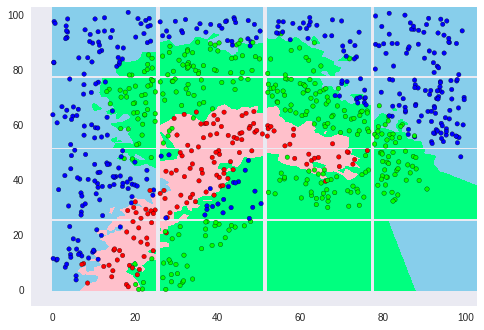

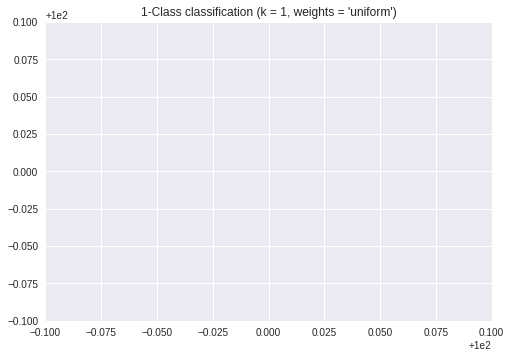

In [60]:
knn_mahalanobis_metric_covariance_matrix_from_region(training_, test_)

In [0]:
X, y = read_dataset_from_csv(dataset3)
training_, test_ = divide_dataset(np.c_[X, y])
X, y = training_[:,:2], training_[:,2]
X_test, y_test = test_[:,:2], test_[:,2]

In [0]:
cmap_light = ListedColormap(['#FFC0CB',  '#00FF7F', '#87CEEB'])
cmap_bold = ListedColormap([ '#FF0000', '#00FF00','#0000FF'])

Accuracy: 0.9209039548022598


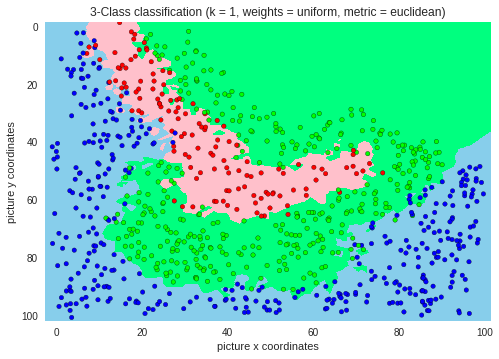

In [64]:
calculate_decision_boundry(X, y,X_test,y_test, 1, 'uniform', 'euclidean',cmap_light,cmap_bold)

Accuracy: 0.9242937853107345


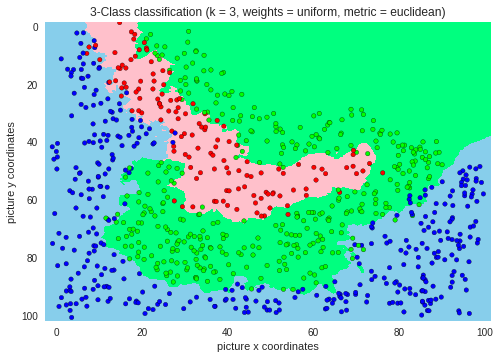

In [65]:
calculate_decision_boundry(X, y,X_test,y_test, 3, 'uniform', 'euclidean',cmap_light,cmap_bold)

Accuracy: 0.9231638418079096


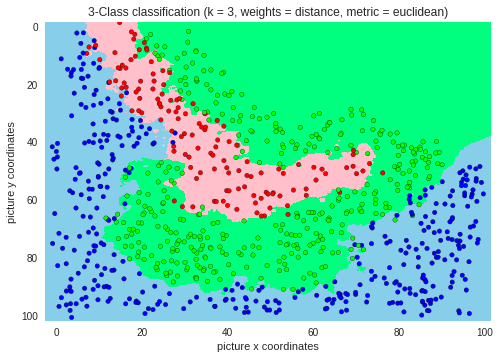

In [66]:
calculate_decision_boundry(X, y,X_test,y_test, 3, 'distance', 'euclidean',cmap_light,cmap_bold)

Accuracy: 0.9231638418079096


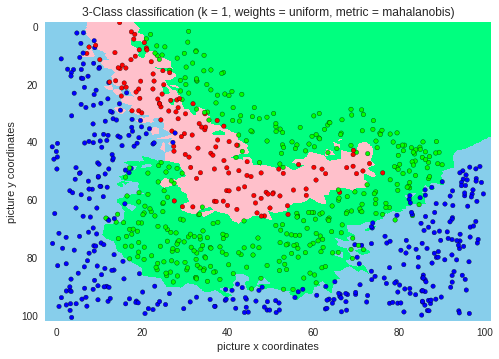

In [67]:
calculate_decision_boundry(X, y,X_test,y_test, 1, 'uniform','mahalanobis',cmap_light,cmap_bold,  metric_params={'VI' :np.linalg.pinv(np.cov(X ,rowvar=False))})

Accuracy = 0.8078540919861811


/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:2961: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=100, right=100
  'left=%s, right=%s') % (left, right))
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:3285: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=100, top=100
  'bottom=%s, top=%s') % (bottom, top))


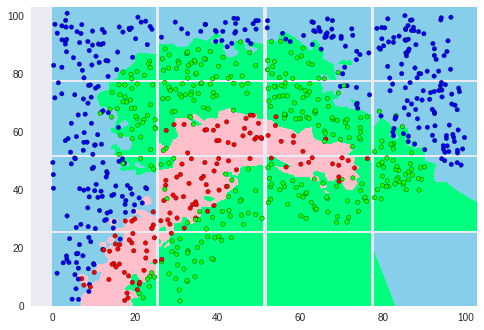

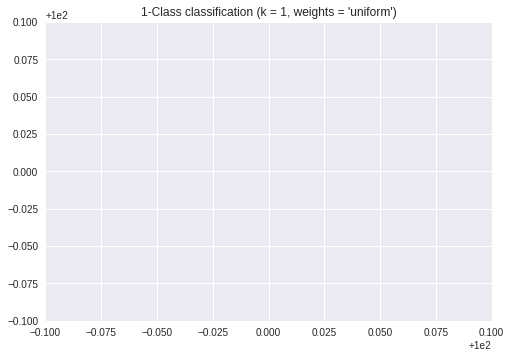

In [68]:
knn_mahalanobis_metric_covariance_matrix_from_region(training_, test_)